In [17]:
import sys, os, itertools, sklearn
sys.path.append('/home/roquero/CausalAggregation/Code')
import pandas as pd
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn import datasets
from sklearn.metrics import auc
from scipy.interpolate import UnivariateSpline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}, linewidth=100000)
from backfitting import Backfitting
from base_environment import BaseEnvironment
from collection_environment import CollectionEnvironment
from regression_method import PolynomialRegression, RandomForestRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


In [18]:
ik_h, se_h = [], (lambda input_samples:input_samples)
ik_x1, se_x1 = ['h'], (lambda input_samples: 2*input_samples[0] + input_samples[1])
ik_x2, se_x2 = ['h', 'x1'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x3, se_x3 = ['x1', 'x2'], (lambda input_samples: -input_samples[0] * 2*input_samples[1] + input_samples[2])
#ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: np.log(1+np.abs(input_samples[0])) + input_samples[1] + input_samples[2])
#ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
#                                         input_samples[0] 
#                                         + input_samples[1]**2
#                                         + 0.5*input_samples[1]*input_samples[2]*input_samples[3]
#                                         - 0.5*input_samples[3]*input_samples[4]
#                                         - input_samples[2]*input_samples[4] + input_samples[5])
ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
                                         (input_samples[0]>0).astype(float)
                                         + (input_samples[1]<-1).astype(float)
                                         + 0.5*(input_samples[1]>0).astype(float)*(input_samples[2]>0.5).astype(float)*(input_samples[3]<0.5).astype(float)
                                         - 0.5*(input_samples[3]<-0.5).astype(float)*(input_samples[4]<0).astype(float)
                                         - (input_samples[2]<0).astype(float)*(input_samples[4]>-0.5).astype(float) + input_samples[5])
ik_x5, se_x5 = ['x2', 'x4', 'y'], (lambda input_samples: 2*input_samples[0] + input_samples[1] - input_samples[2] + input_samples[3])

In [59]:
fh = {'input_keys':ik_h, 'structural_eq': se_h}
f1 = {'input_keys':ik_x1, 'structural_eq': se_x1}
f2 = {'input_keys':ik_x2, 'structural_eq': se_x2}
f3 = {'input_keys':ik_x3, 'structural_eq': se_x3}
f4 = {'input_keys':ik_x4, 'structural_eq': se_x4}
f5 = {'input_keys':ik_x5, 'structural_eq': se_x5}
fy = {'input_keys':ik_y, 'structural_eq': se_y}

sh = lambda n_samples: np.random.normal(size=n_samples)/200
s1 = lambda n_samples: np.random.normal(size=n_samples)
s2 = lambda n_samples: np.random.normal(size=n_samples)
s3 = lambda n_samples: np.random.normal(size=n_samples)
s4 = lambda n_samples: np.random.normal(size=n_samples)
s5 = lambda n_samples: np.random.normal(size=n_samples)
sy = lambda n_samples: np.random.normal(size=n_samples)/500

topo_order = ['h','x1','x2','x3','x4','y','x5']
y_key = 'y'
x_key = ['x1','x2','x3','x4','x5']

structural_equation_dict = {'x1':f1, 'x2':f2, 'x3':f3, 'y':fy, 'x4':f4, 'x5':f5, 'h':fh}
disturbance_sampler_dict = {'x1':s1, 'x2':s2, 'x3':s3, 'y':sy, 'x4':s4, 'x5':s5, 'h':sh}

base = BaseEnvironment(structural_equation_dict, disturbance_sampler_dict, topo_order, y_key, x_key)
coll_env = CollectionEnvironment(base)

In [60]:
coll_env.add_env('e1', {'x1':{'type':'independent'},'x2':{'type':'independent'}, 'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e2', {'x2':{'type':'independent'},'x4':{'type':'independent'}}, 10000)
coll_env.add_env('e3', {'x4':{'type':'independent'},'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e4', {'x1':{'type':'independent'},'x5':{'type':'independent'}}, 10000)


In [61]:
coll_env.env['e1'].data['X'].mean(axis=1)

array([0.010, 0.004, 0.009, 0.534, 0.306])

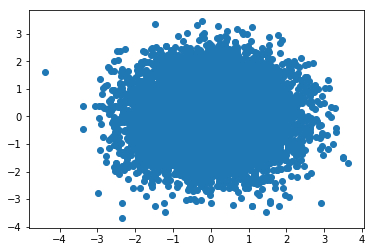

In [62]:
plt.scatter(coll_env.env['e1'].data['X'][0,:],coll_env.env['e1'].data['X'][1,:])

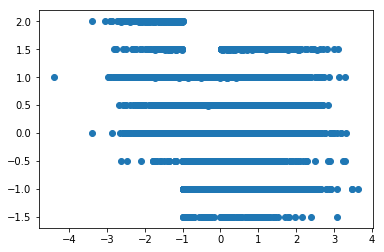

In [63]:
plt.scatter(coll_env.env['e1'].data['X'][0,:],coll_env.env['e1'].data['Y'])

In [64]:
params_method = {'regression_method':'HuberRegressor',
                 'power_features': {
                     'e1':3,
                     'e2':2,
                     'e3':2,
                     'e4':2,
                     'e5':2,
                                     },
                 'selected_features':{
                     'e1':['1','x1^0', 'x2^0','x2^2',  'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0',  'x2^0x3^0', 'x3^2', 'x1^3',
                           'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3'],
                     'e2':['x2^0x4^0'],
                     'e3':['x3^0x4^0'],
                     'e4':['x1^0x5^0'],
                 },
                 'n_estimators':60
                }

backfit = Backfitting(RandomForestRegression, 
                      'boosting',
                      max_n_iter=3,
                      gap_convergence=1e-5,
                      warm_start=False, 
                      params_method=params_method)
                      
res = backfit.fit(coll_env)

100%|██████████| 3/3 [01:26<00:00, 28.99s/it]


In [65]:
backfit.output_model_variation

{'e1': [0.09841700381937159, 0.06226300457917032],
 'e2': [0.013373339829141252, 0.06742407277966847],
 'e3': [0.07109978361664807, 0.03169996885223276],
 'e4': [0.09268077045097113, 0.07141616063077981]}

In [66]:
samples = np.random.normal(size=(6,10))
samples

array([[-0.063, -0.850, -1.733, -0.907, 0.524, 1.012, -0.118, -0.006, 0.114, -1.235],
       [0.178, -1.314, 0.302, 0.334, -1.544, -0.403, -1.140, -0.534, 0.394, -0.318],
       [-0.291, 1.437, -0.912, -0.952, -0.213, 1.588, 0.322, -0.638, 0.166, 0.667],
       [0.041, -1.098, -2.020, -2.343, -1.687, -1.107, 1.346, -0.227, -0.444, -0.234],
       [-2.040, -0.971, 0.277, 0.272, 0.338, 0.653, -0.673, 1.082, -0.193, 1.024],
       [0.838, -0.348, -0.997, -0.992, 0.587, -1.808, 0.847, -0.155, 1.976, -0.976]])

In [52]:
backfit.true_function_y(backfit.x_train_full[:,:10])
backfit.output_function_merged(backfit.x_train_full[:,:10])

array([1.000, -1.000, 0.000, -1.000, -1.000, 0.000, -0.500, 1.000, -0.500, -1.000])

array([2.299, 0.124, -0.097, -1.285, -0.988, 0.763, 0.841, 1.999, -0.630, -0.256])

In [53]:
backfit.true_function_y(samples)
backfit.output_function_merged(samples)

array([0.500, 1.000, 0.000, -1.000, 0.000, -0.500, -1.000, -1.000, 0.000, 0.000])

array([2.443, 2.763, -0.139, -0.589, 0.014, 1.326, -0.698, -0.244, 0.407, 1.239])

In [54]:
backfit.evaluate_gap(samples)

1.2769205712573526

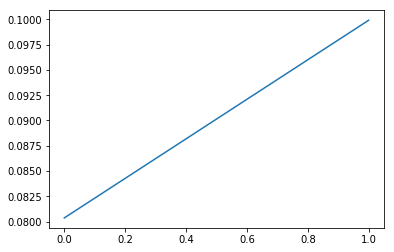

In [55]:
 _ = plt.plot(backfit.output_model_variation['e2'])

In [56]:
for values in backfit.output_model_dict.values():
    print(values.coef_())
    print(values.get_feature_names())

In [57]:
backfit.output_function_dict['e1'](np.array([1,1,1]).reshape(1,-1))

array([-1.149])

In [58]:
backfit.output_function_dict['e1']

<function backfitting.Backfitting.fit.<locals>.f_boosting.<locals>.<lambda>(u)>

In [72]:
reg = RandomForestRegressor(n_estimators=1000)

In [73]:
reg.fit(coll_env.env['e1'].data['X'].T,coll_env.env['e1'].data['Y'])

 10%|█         | 1/10 [31:28<4:43:16, 1888.52s/it]


RandomForestRegressor(n_estimators=1000)

In [74]:
reg.predict(coll_env.env['e1'].data['X'].T)[:20]

array([0.098, 0.329, 0.859, 0.348, 0.058, -0.953, -0.410, 0.209, 0.235, -0.849, 0.320, 0.080, 0.127, 0.201, -0.969, 0.464, 0.221, 0.761, 0.853, 0.111])

In [75]:
coll_env.env['e1'].data['Y'][:20]

array([0.497, 0.499, 1.002, 0.498, -0.002, -1.001, -0.498, 0.000, 0.501, -1.003, -0.001, -0.001, -0.002, 0.499, -1.004, 0.502, 0.504, 1.000, 0.999, -0.001])